# Pipeline for analyzing the RA data - Step 1 to 6

In [1]:
d = {'methotrexaat': [1135, 2057, 8, 8], 'leflunomide': [149, 2839, 16, 0], 'sulfasalazine': [184, 2810, 3, 8], 'hydroxychloroquine': [231, 2771, 3, 2], 'azathioprine': [27, 2963, 2, 1], 'goud': [20, 2972, 0, 2], 'abatacept': [50, 2946, 0, 0], 'adalimumab': [160, 2856, 1, 0], 'certolizumab': [27, 2967, 0, 0], 'etanercept': [137, 2863, 14, 0], 'golimumab': [13, 2975, 4, 0], 'infliximab': [35, 2961, 3, 1], 'rituximab': [7, 2984, 0, 0], 'tocilizumab': [37, 2955, 0, 2], 'depomedrol': [157, 2833, 6, 18], 'prednison': [585, 2483, 5, 20], 'corticosteroiden': [6, 2984, 0, 6]}
print(len(d))

17


In [1]:
# Initializing Pandas & Matplotlib
#import sys
#sys.path.append('/exports/reum/tdmaarseveen/modules/')
import os
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplt
import io
import re
import numpy as np
import datetime
import EMR_functions as em
import Visualize as vis
from acronyms import ACRONYM_MAP
from acronyms import MEDICINE
from acronyms import TYPO_ACRONYM_MAP
from bokeh import __version__ as bv


def getcwd():
    cwd = os.getcwd()
    return cwd

def read_csv(f_name):
    return pd.read_csv(f_name, sep="|")

def remove_rtf(df_rtf, column):
    df_clean = df_rtf[~df_rtf[column].str.contains(r"^\{.*\}.*", na=False)]
    return df_clean


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + plt.__version__)
print('numpy version:\t\t' + np.__version__)
print('Bokeh version:\t\t' + bv)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.14.3
Bokeh version:		0.12.16


### Shortcuts

In [2]:
pipe_df= 1
print(os.getcwd())

if pipe_df == 0:
    df_REU = read_csv(r'output_files/DF_REU.csv')
    pc_df = em.Processing(df_REU)
    #pc_df.createTableREUBEL()
elif pipe_df == 1:
    df_REUBEL = read_csv(r'output_files/DF_REUBEL.csv')
    pc_df = em.Processing(df_REUBEL)
elif pipe_df == 2 or pipe_df == 4:
    df_test = pd.read_csv(r'output_files/DF_test.csv', index_col=0, sep="|")
    df_typo_val = pd.read_csv(r'output_files/DF_typoValidation.csv', index_col=0, sep="|")
    df_explore = pd.read_csv(r'output_files/DF_explore.csv', index_col=0, sep="|")
    pc_df = em.Processing(df_explore)
    if pipe_df == 4:
        pc_df.splitDatasetIntoCategories(0.5, 0, 777)
elif pipe_df == 3:
    df_nlp = read_csv(r'output_files/DF_REUBEL_nlp.csv') # NA in file?
    pc_df = em.Processing(df_nlp)

# Prints 45
    
#print(pc_df.getPatients())
print(len(pc_df.getDF()))

C:\Users\tdmaarseveen\Desktop\EMR_mining
45012


#### Choosing a replacing char for newline

In [4]:
print(len(df_typo_val))
print(len(df_explore))
print(len(df_explore['PATNR'].unique()))
print(len(df_typo_val['PATNR'].unique()))

NameError: name 'df_typo_val' is not defined

In [3]:
df_REUBEL[df_REUBEL['XANTWOORD'].str.contains('^', regex=False)]['XANTWOORD']

3983     zowel thuis asl ) ^ - niet opgenomen . @ inges...
23931    iom pte afwachtend beleid , bij dikke stijve g...
Name: XANTWOORD, dtype: object

# Step 1: Formatting data from files into pandas dataframe

### 1.1 LOADING DDR_A table

#### Convert DDR_A table from UTF16-le to ASCII 
    The DDR_A is converted to ASCII
    Reminder: The DDR_A input table must first be cleansed of newlines!

In [4]:
em.convert_to_ascii(r"output_files/proc_DDR_A.txt", r'fin_DDR_A.txt')

### Loading DDR_A table & Taking patient selection with REU dossier

1. Taking all of the rows where CATEGORIE equals REU
2. Converting DATUM to DatetimeIndex
3. Calculating the total timespan for every patient (this function causes errors if you havent loaded python3.5 and conda3)
    - first sort values on patientnr and datum, then group by the patientnr and then select the greates difference
4. Converting Time to Integer
5. Replacing empty strings in XANTWOORD and DUURTOT with Nan
6. Removing the Nans in XANTWOORD & STELLING
7. Writing dataframe to DF_REU.csv
8. Only selecting rows where STELLING == Beleid
9. Writing dataframe to DF_REUBEL.csv


In [5]:
conv_ddrA = em.build_convenient_list(r"output_files/fin_DDR_A.txt", "|", "ascii")
df_ddrA = em.list_to_df(conv_ddrA)

pc_df = em.Processing(df_ddrA)


pc_df.createTableREU()
pc_df.createTableREUBEL()
print(pc_df.getDim())

conv_ddrA = None

#dcm_mv = build_convenient_list(r"dbo.proc_DCM_MV.txt", "|", "utf-16")
#df_mv = list_to_df(dcm_mv)
#dcm_mv = None


/exports/reum/tdmaarseveen/EMR_mining/EMR_functions.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df['DATUM'] = pd.DatetimeIndex(pd.to_datetime(self.df['DATUM'])).tz_localize('UTC')


Rows: 45012	Columns: 56


In [5]:
df_ddrA[df_ddrA['STELLING'].isin(['Conclusie'])].to_csv('output_files/DF_DDRACON.csv', sep='|', index=False)

# Step 2: Observing Data (Total Dataset)


### DDR_A Plot: Total timespan per patient in days (REU)

Text(-0.1,0.5,'Number of dossier entries')

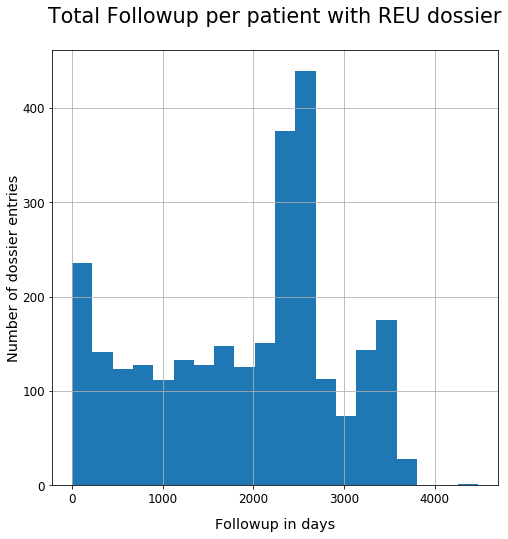

In [59]:
plt.rcParams.update({'font.size': 12})
fig = pc_df.getDF().groupby('PATNR')['DUURTOT'].mean().hist(bins=20, figsize = (8,8))
fig.set_title('Total Followup per patient with REU dossier', x=0.5, y=1.05, ha='center', fontsize='xx-large')

fig.text(0.5, -0.1, 'Followup in days', ha='center', fontsize='large', transform=fig.transAxes)
fig.text(-0.1, 0.5, 'Number of dossier entries', va='center', rotation='vertical', fontsize='large', transform=fig.transAxes)


## DDR_A Plot: Unique dossier entries added per day with REU category

### Description figure:
EZIS/ HIX started being utilized in 2011, which explains the sudden peak in 2011. Data before 2011 -> (old dossiers from meteor -> converted to HIX). Those rows don't have a Beleid section as well.
These old dossiers are characterized with the line 'Conversie gegevens meteor'. 

Text(-0.1,0.5,'Number of dossier entries')

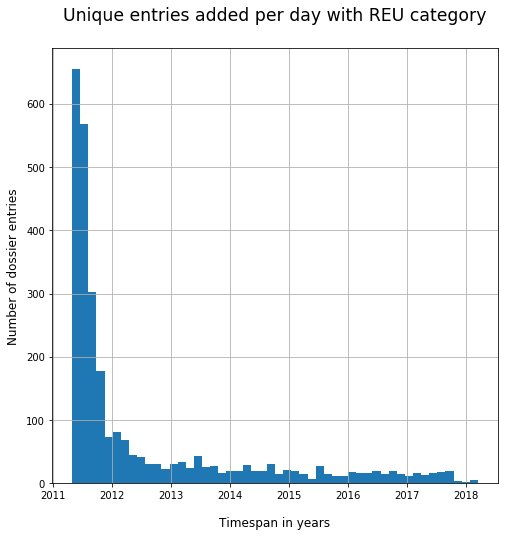

In [19]:
plt.rcParams.update({'font.size': 10})
df_date = pc_df.getDF().copy()
df_date['DATUM'] = pd.DatetimeIndex(pd.to_datetime(pc_df.getDF()['DATUM'])).tz_localize('UTC')
fig2 = df_date.groupby(['DOSSIERID'])['DATUM'].nsmallest(1).hist(bins=50, figsize = (8,8)) 

fig2.set_title('Unique entries added per day with REU category', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig2.text(0.5, -0.1, 'Timespan in years', ha='center', fontsize='large', transform=fig2.transAxes)
fig2.text(-0.1, 0.5, 'Number of dossier entries', va='center', rotation='vertical', fontsize='large', transform=fig2.transAxes)

In [16]:
df_date.nsmallest(1, columns=['DATUM'])


,ID,LIJSTID,CATEGORIE,DATUM,TIJD,MUTDAT,MUTTIJD,GEBRUIKER,DEFINITIEF,COMPLEET,...,VRLIJSTTYPEID,DOSSIERID,PARENTBEANTWID,REALSUBID,EENHEIDCD,MODEL_ID,CONFIG,DATA,STELLING,DUURTOT
578,96688766,CS00000503,REU,2011-04-29 00:00:00+00:00,17:31,2011-04-29 00:00:00,17:33,08585,False,False,...,PVC,1000003342,NaN,NaN,NaN,NaN,NaN,NaN,Beleid,2481


### Determine patients without REU category

In [29]:
print(len(em.determineIntersection(df_ddrA['PATNR'], pc_df.getDF()['PATNR'])))

2771


### Patienten die wel een conclusie maar geen beleid hebben 

In [17]:
a7 = df_REU[df_REU['STELLING'].isin(['Conclusie'])]['PATNR'].unique()
a7 = a7[a7 != np.array(None)]
a8 = a8[a8 != np.array(None)]
print(len(np.setdiff1d(a7, a8)))
#print(np.setdiff1d(a7, a8))


222


### Frequency of Methotrexaat in different parts of the dossier (default: DF_REU)

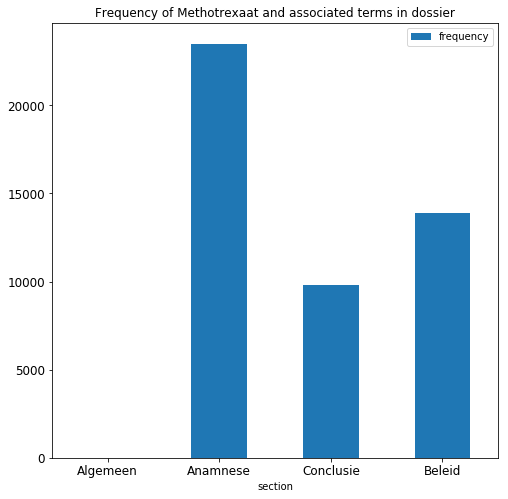

In [10]:
matchers = ['methotrexaat', 'mtx']
freq_list = []

for x in ['Algemeen', 'Anamnese', 'Conclusie', 'Beleid']:
    matching = [s for s in pc_df.getDF()[pc_df.getDF()['STELLING'].isin([x])]['XANTWOORD'] if any(xs in s for xs in matchers)]
    freq_list.append(len(matching))

df = pd.DataFrame({'section':['Algemeen', 'Anamnese', 'Conclusie', 'Beleid'], 'frequency':freq_list})

ax = df.plot(kind='bar', title ="Frequency of Methotrexaat and associated terms in dossier", x='section', figsize=(8, 8), legend=True, fontsize=12, rot=0)



# Step 3: Creating Subsets


### Creating the Golden standard / Exploration Data set

# Step 4: Observing Data (Exploration set)

## Analyzing Exploration set: occurences of Medication (typos excluded)

In [ ]:
df_REUBEL = read_csv(r'output_files/DF_REUBEL.csv')
pc_df = em.Processing(df_REUBEL)
df_total, df_gold = em.midasTouch(pc_df.getDF())
print(len(df_gold))
pc_df.setDF(df_total)
df_test, df_typo_val, df_explore= em.createSubsets(pc_df.getDF(), 12345, 0.15, 0.15)

print(len(df_total['PATNR'].unique()))
print(len(df_typo_val['PATNR'].unique()))
print(len(df_explore['PATNR'].unique()))
print(len(df_test['PATNR'].unique()))

pc_df.setDF(df_explore)

pc_df.getDim()

print(len(df_explore)/2)
print(len(df_typo_val)/2)


print(pc_df.getDF().iloc[2780]['XANTWOORD']) # Ter controle

In [15]:
freq_list = []
for i in MEDICINE:
    matching = [s for s in pc_df.getDF()['XANTWOORD'] if any(xs in s for xs in [i])]
    freq_list.append(len(matching))


### generate Barplot for frequency per Medication

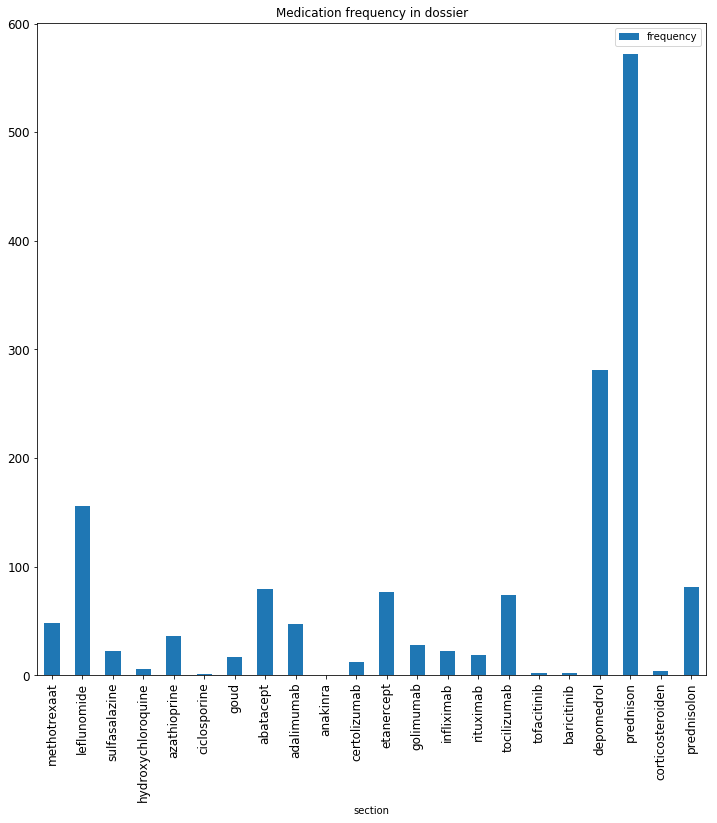

In [16]:

df_match = pd.DataFrame({'section':MEDICINE, 'frequency':freq_list})

ax = df_match.plot(kind='bar', title ="Medication frequency in dossier", x='section', figsize=(12, 12), legend=True, fontsize=12, rot=90)


### Generate Circleplot for frequency per Medication

/usr/local/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


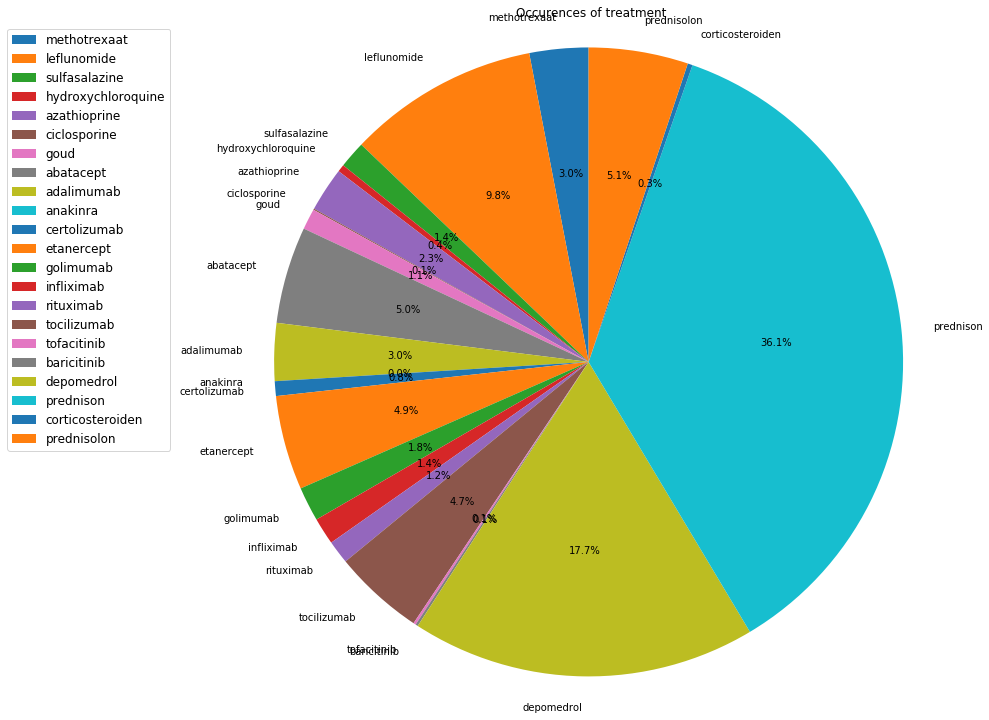

In [18]:
pyplt.figure(figsize=[10, 10])

pyplt.pie(
    freq_list,
    labels=MEDICINE,
    shadow=False,
    startangle=90,
    autopct='%1.1f%%',
    )

pyplt.axis('equal', labeldistance=1.05)
pyplt.title('Occurences of treatment')
pyplt.legend(freq_list, labels=MEDICINE, loc="best", bbox_to_anchor=(-0.1, 1., 0., 0.), fontsize='large')

pyplt.tight_layout()

pyplt.savefig('figures/exploringData/PieChartMed.png', bbox_inches='tight')
pyplt.show()


# Step 5: Processing Typos (Exploration set)

### Determing possible typos in acronyms
This function generates a list of possible typos in the acronyms -> this list can be used to improve the performance of the typo algorithm when searching for typos in acronyms.

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

pc_df.typoAnalyzing('XANTWOORD', ACRONYM_MAP.keys())

ofile = open(r'typoAlgorithm/CandidateTyposAcronym.txt', 'w')

count_obj = Counter(pc_df.getTypos())
for x in count_obj.most_common():
    text = "Woord: " + str(x[0]) + "\t\tFrequentie: " + str(x[1])
    try:
        ofile.write(text + "\n")
    except:
        print('not possible: ' + str(x[0]))
ofile.close()


### Figure: Proportion Typos (Pie chart)
Warning: Proportion of typos in Acronyms excluded 

First the amount of typos in Medication is predicted

/usr/local/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


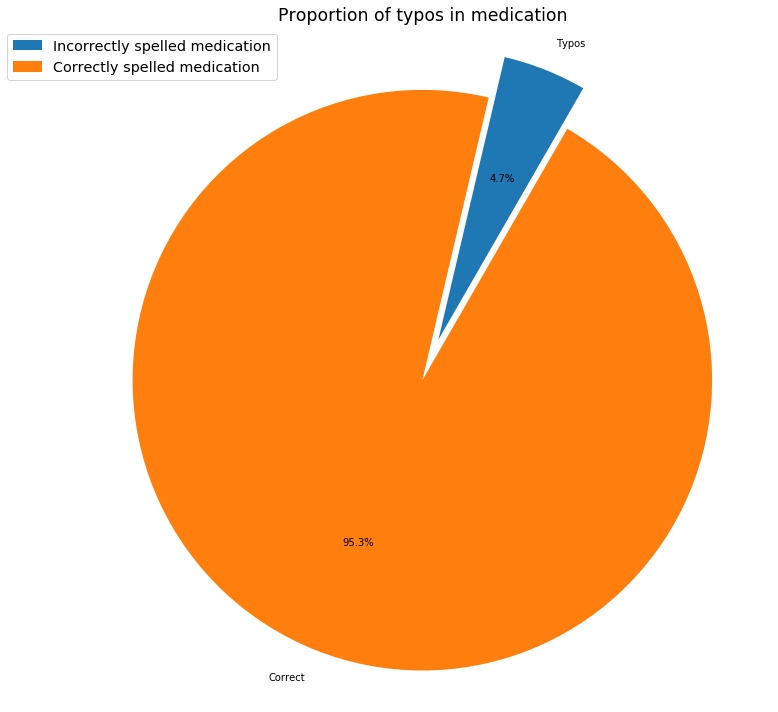

In [8]:
import matplotlib.pyplot as plt

global l_correct

l_correct = []

def correct_words(text):
    for x in re.split(' |, |\&|\n',text):
        if str(x) in MEDICINE or str(x) in ACRONYM_MAP.keys():
            l_correct.append(x)
    return

pc_df.typoAnalyzing('XANTWOORD', MEDICINE)
pc_df.getDF()['XANTWOORD'].apply(lambda x : correct_words(x))

freq_list = [len(pc_df.getTypos()), len(l_correct)]
plt = vis.circlePlot(freq_list, ['Incorrectly spelled medication', 'Correctly spelled medication'], 'Proportion of typos in medication', [0.15, 0])
plt.savefig('figures/typoExploring/TypoProportionPieChart.png', bbox_inches='tight')
plt.show()




### Figure: Word cloud of most occuring typos 

In [22]:

import importlib.util
spec = importlib.util.spec_from_file_location("wordcloud", "/exports/reum/tdmaarseveen/modules/word_cloud/wordcloud/wordcloud.py")
wordcloud = importlib.util.module_from_spec(spec)
spec.loader.exec_module(wordcloud)
wordcloud.WordCloud()

from collections import Counter
import matplotlib.pyplot as plt
l_typo = pc_df.getTypos()
word_could_dict=Counter(l_typo)

wordcloud = wordcloud.WordCloud(width = 3000, height = 1500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.savefig('figures/typoExploring/TyposWordcloud.png', bbox_inches='tight')
plt.close()

## Create Samples for Validation

First: Determining CutOff
1. This function determines all variations of a medication within a certain range of a Damerau levenshteinscores. 
2. And creates a 'cut off'-plot in Bokeh
3. Also generates DF_CutOff.csv, which is a dataframe that consists of normalized frequency per variation in medication

Then: 
The data is split into three categories -> which are later on combined to guarantee diversity in the data 
Test data is basically stratified on typos
![title](img/TypoValidationSample.png)

In [3]:
pc.setDF(df_typo_val)
pc_df.splitDatasetIntoCategories(0.5, 0, 777) 


[0.0, 0.0, 0.0, 0.0, 2, 8]
[7, 0.0, 0.0, 0.0, 0.0, 104]
[2, 0.0, 0.0, 0.0, 0.0, 1]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1, 0.0, 0.0, 0.0, 0.0, 8]
[0.0, 0.0, 0.0, 0.0, 4, 10]
[1, 3, 1, 0.0, 961, 3759]
[2, 0.0, 11, 2, 9, 87]
[0.0, 0.0, 0.0, 38, 3723, 16287]
[2, 4, 0.0, 0.0, 12, 6]
[2, 0.0, 3, 1, 126, 1879]
[2, 11, 0.0, 3, 32, 3954]
[1, 0.0, 0.0, 2, 18, 177]
[0.0, 0.0, 0.0, 2, 62, 857]
[1, 2, 2, 1, 13, 7]
[0.0, 0.0, 0.0, 0.0, 1, 21]
[0.0, 0.0, 0.0, 0.0, 0.0, 588]
[9, 3, 3, 8, 7, 314]
[19, 1, 18, 13, 463, 3608]
[12, 0.0, 18, 1, 70, 48]
[0.0, 0.0, 0.0, 0.0, 0.0, 1]
[0.0, 4, 1, 0.0, 0.0, 0.0]


/usr/local/Anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:5175: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  other.index).difference(self.columns).tolist()


certolizumab Calculated amount of Typos: 8
etanercept Calculated amount of Typos: 19
hydroxychloroquine Calculated amount of Typos: 6
depomedrol Calculated amount of Typos: 17
prednison Calculated amount of Typos: 21
anti-tnf Calculated amount of Typos: 7
abatacept Calculated amount of Typos: 6
golimumab Calculated amount of Typos: 12
prednisolon Calculated amount of Typos: 11
adalimumab Calculated amount of Typos: 2
leflunomide Calculated amount of Typos: 28
infliximab Calculated amount of Typos: 2
sulfasalazine Calculated amount of Typos: 9
methotrexaat Calculated amount of Typos: 3
azathioprine Calculated amount of Typos: 1
148


#### Calculate mean DL- cut-off & STD

In [42]:
import statistics
def getDictCutOff():
    d_cutoff = {}
    try:
        df_CutOff = read_csv(r'input_files/DF_CutOff.csv')
        for x in df_CutOff:
            #print("Cut off " + x + " =\t " + str(df_CutOff[x].idxmin()+1) + " (" + str(df_CutOff[x].min()) + ")")
            d_cutoff[x] = int(df_CutOff[x].idxmin()+1)
    except:
        if init == 0:
            print("ERROR: There is no DF_CutOff -> you probably have to" + \
                  " generate a new DF_CutOff with the" + \
                  " generateTypoCuttOffPlot() function")
    return d_cutoff

d_cutoff = getDictCutOff()
print(sum(d_cutoff.values())/len(d_cutoff.values()))
print(statistics.stdev(d_cutoff.values()))
print(statistics.median(d_cutoff.values()))

1.8181818181818181
0.9579921282290986
2.0


# Step 6: Validating Typo Algorithm


In [3]:
df_gold = pd.read_csv(r'TypoValTrain/updated_gold_standard.csv', index_col=1, sep="|")
df_typo = pd.read_csv(r'TypoValTrain/Sample2_corrected.csv', index_col=1, sep="|") # corrected
df_notypo = pd.read_csv(r'TypoValTrain/Sample4_corrected.csv', index_col=0, sep="|") # corrected
df_nomed = pd.read_csv(r'TypoValTrain/Sample3.csv', index_col=0, sep="|")

val = em.ValidateTypoAlgorithm(df_nomed, df_notypo, df_typo, df_gold)
val.calculatePerformanceTotal()
df_mismatches = val.getMismatches()
df_mismatches.to_csv('TypoValTrain/DF_Mismatches_groups.csv', sep='|', index=False)
print(val.getPerformance())
print(val.getPerformanceMedicine())
print(val.getPerformancePerLine())

   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
unrecognized med in gold standard:  corticosteroiden
unrecognized med in gold standard:  corticosteroiden
   a true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
   z true pos: 0| false pos: 0| true neg: 0| false neg: 0
unrecognized med in gold standard:  ??
   t true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
unrecognized med in gold standard:  ytrium
unrecognized med in gold standard:  500
   a true pos: 0| false pos: 0| true neg: 0| false neg: 1
   g true pos: 0| false pos: 0| true neg: 0| false neg: 1
   a true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| false pos: 0| true neg: 0| false neg: 1
   p true pos: 0| false pos: 0| true neg: 0| false neg: 1
   s true pos: 0| 

{'true_pos': 3034, 'true_neg': 1239, 'false_pos': 65, 'false_neg': 63}
{'triamcinolon': [0, 0, 0, 0], 'methylprednisolon': [0, 0, 0, 0], 'methotrexaat': [1162, 2057, 8, 8], 'leflunomide': [163, 2839, 16, 0], 'sulfasalazine': [191, 2810, 3, 8], 'hydroxychloroquine': [236, 2771, 3, 2], 'azathioprine': [29, 2963, 2, 1], 'ciclosporine': [0, 2990, 0, 0], 'goud': [21, 2972, 0, 2], 'abatacept': [52, 2946, 0, 0], 'adalimumab': [163, 2856, 1, 0], 'anakinra': [0, 2990, 0, 0], 'certolizumab': [27, 2967, 0, 0], 'etanercept': [139, 2863, 14, 0], 'golimumab': [13, 2975, 4, 0], 'infliximab': [35, 2961, 3, 1], 'rituximab': [7, 2984, 0, 0], 'tocilizumab': [39, 2955, 0, 2], 'tofacitinib': [0, 2990, 0, 0], 'baricitinib': [0, 2990, 0, 0], 'depomedrol': [160, 2833, 6, 19], 'prednison': [597, 2483, 5, 20]}
{'true_pos': 1627, 'true_neg': 1239, 'false_pos': 75, 'false_neg': 88}


#### Calculate entries with atleast 1 medication in Gold standard

In [3]:
df_gold = pd.read_csv(r'TypoValTrain/updated_gold_standard.csv', index_col=1, sep="|")
print(len(df_gold))

print(len(df_gold[df_gold['RA medicatie ja/nee']==1.0]))
print(len(df_gold[df_gold['Drug 1'].notnull()]))

2993
1786
1789


## Display overall Performance Characteristics

In [5]:
em.overviewPerformanceDict(val.getPerformance().copy())

PPV:		0.979025492094224
NPV:		0.9516129032258065
Sensitivity:	0.9796577332902809
Specificity:	0.9501533742331288
Accuracy:	0.9709157009770507


## Display overall Performance Characteristics per Medication (Raw output)

In [ ]:
for med, value in val.getPerformanceMedicine().items(): 
    if value[1] != int(len(df_typo_val)/2): # Don't visualize if not present in test data
        print('med : ' + med)
        print('true_pos: ' + str(value[0]) + '\ttrue_neg: ' + str(value[1]) + '\tfalse_pos: ' + str(value[2]) + '\tfalse_neg: ' + str(value[3]))
        l_perf = em.overviewPerformanceList(value)
        print('PPV:\t\t' + str(l_perf[0]) + '\nNPV:\t\t' + str(l_perf[1]) + '\nSensitivity:\t' + str(l_perf[2]) + \
         '\nSpecificity:\t' + str(l_perf[3]) + '\nAccuracy:\t' + str(l_perf[4]))
        print('')

## Visualize performance characteristics per Medication (Scatter plot)

l_exclude = list with excluded medication. 
#### Reasons for exclusion
1. Name doesnt represent a medication but a groupname
2. Medication isn't present in the test set
3. Medication wasnt featured on the entity recognition list

Groupnames are excluded, as well as medication that weren't mentioned in the test set.

In [6]:
# Formatting performance dict to dataframe
l_exclude = ['triamcinolon','methylprednisolon', 'prednisolon', 'prednison', 'anti-tnf', 'jak-inhibitor', 'dmard', 'baricitinib', 'tofacitinib', 'anakinra', 'ciclosporine', 'corticosteroiden']
d_performance = val.getPerformanceMedicine().copy()
freq_list = []

d_performance = dict([e for e in d_performance.items() if e[0] not in l_exclude])
d_performance['overall'] = [val.getPerformance().copy()['true_pos'], val.getPerformance().copy()['true_neg'],
                            val.getPerformance().copy()['false_pos'], val.getPerformance().copy()['false_neg']]

for med, value in d_performance.items():
    l_perf = em.overviewPerformanceList(value)
    d_performance[med] = l_perf 
    
print(d_performance)


{'methotrexaat': [0.9931623931623932, 0.9961259079903148, 0.9931623931623932, 0.9961259079903148, 0.9950540958268933], 'leflunomide': [0.9106145251396648, 1.0, 1.0, 0.9943957968476357, 0.9946984758117959], 'sulfasalazine': [0.9845360824742269, 0.9971611071682044, 0.9597989949748744, 0.998933522929257, 0.9963479415670651], 'hydroxychloroquine': [0.9874476987447699, 0.999278759466282, 0.9915966386554622, 0.9989185291997116, 0.998339973439575], 'azathioprine': [0.9354838709677419, 0.9996626180836707, 0.9666666666666667, 0.9993254637436763, 0.9989983305509182], 'goud': [1.0, 0.9993275050437121, 0.9130434782608695, 1.0, 0.9993322203672788], 'abatacept': [1.0, 1.0, 1.0, 1.0, 1.0], 'adalimumab': [0.9939024390243902, 1.0, 1.0, 0.999649982499125, 0.9996688741721854], 'certolizumab': [1.0, 1.0, 1.0, 1.0, 1.0], 'etanercept': [0.9084967320261438, 1.0, 1.0, 0.9951338199513382, 0.9953580901856764], 'golimumab': [0.7647058823529411, 1.0, 1.0, 0.9986572675394427, 0.9986631016042781], 'infliximab': [0.

#### Assign new keys for Figure -> user-friendly

In [9]:


print(val.getPerformance())
d_performance['mtx'] = d_performance.pop('methotrexaat')
d_performance['lef'] = d_performance.pop('leflunomide')
d_performance['ssz'] = d_performance.pop('sulfasalazine')
d_performance['hcq'] = d_performance.pop('hydroxychloroquine')
d_performance['aza'] = d_performance.pop('azathioprine')

d_performance['abt'] = d_performance.pop('abatacept')
d_performance['ada'] = d_performance.pop('adalimumab')
d_performance['certo'] = d_performance.pop('certolizumab')
d_performance['eta'] = d_performance.pop('etanercept')
d_performance['goli'] = d_performance.pop('golimumab')
d_performance['ifx'] = d_performance.pop('infliximab')
d_performance['rtx'] = d_performance.pop('rituximab')
d_performance['toc'] = d_performance.pop('tocilizumab')
d_performance['depo'] = d_performance.pop('depomedrol')
d_performance['gold'] = d_performance.pop('goud')


{'true_pos': 3034, 'true_neg': 1239, 'false_pos': 65, 'false_neg': 63}


### Create Insightful figure displaying the performance of the extraction per Med

In [16]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
def performancePlot(df, title):
    """
    Params:
        df = dataframe where the different values per key are the 
            performance characteristics
        title = title of the plot
    """
    plt.figure(figsize=(10, 10))
    colors = ['m', 'b', 'g', 'y', 'r']
    markers = ['s', 'o', 'v', '^',  'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    l_keys = list(df.keys())
    l_values = list(df.values())
    print(l_values)
    lg = ['   Overall\n   performance'] + ['']*2  + l_keys[1:]
    
    for xe, ye in zip(l_keys, l_values):
        ix = 0
        for i in ye:
            if xe == 'overall':
                plt.scatter('', .2, marker=markers[ix], s=1, alpha=0, color=colors[ix])
                plt.scatter(xe, i, marker=markers[ix], s=800, alpha=.8, edgecolors='black', linewidths=1.5, color=colors[ix])
                plt.scatter(' ', .3, marker=markers[ix], s=1, alpha=0, color=colors[ix])
                
            else :
                plt.scatter(xe, i, marker=markers[ix], s=600, alpha=.8, edgecolors='black', linewidths=1, color=colors[ix])
            ix += 1
    
    legend_elements = [Line2D([0], [0], marker=markers[0], color=colors[0], label='Ppv', markersize=20, markeredgecolor='black'),
                       Line2D([0], [0], marker=markers[1], color=colors[1], label='Npv', markersize=20, markeredgecolor='black'),
                       Line2D([0], [0], marker=markers[2], color=colors[2], label='Sensitivity', markersize=20, markeredgecolor='black'),
                       Line2D([0], [0], marker=markers[3], color=colors[3], label='Specificity', markersize=20, markeredgecolor='black'),
                       Line2D([0], [0], marker=markers[4], color=colors[4], label='Accuracy', markersize=20, markeredgecolor='black')]       
    plt.legend(handles=legend_elements)      
    
    plt.axes().set_xticklabels(lg, rotation='vertical') 
    for i, t in enumerate(plt.axes().get_xticklabels()):
        if i == 0:
            t.set_rotation(0)
    
    plt.title(title)
    return plt



{'overall': [0.979025492094224, 0.9516129032258065, 0.9796577332902809, 0.9501533742331288, 0.9709157009770507], 'mtx': [0.9931623931623932, 0.9961259079903148, 0.9931623931623932, 0.9961259079903148, 0.9950540958268933], 'lef': [0.9106145251396648, 1.0, 1.0, 0.9943957968476357, 0.9946984758117959], 'ssz': [0.9845360824742269, 0.9971611071682044, 0.9597989949748744, 0.998933522929257, 0.9963479415670651], 'hcq': [0.9874476987447699, 0.999278759466282, 0.9915966386554622, 0.9989185291997116, 0.998339973439575], 'aza': [0.9354838709677419, 0.9996626180836707, 0.9666666666666667, 0.9993254637436763, 0.9989983305509182], 'abt': [1.0, 1.0, 1.0, 1.0, 1.0], 'ada': [0.9939024390243902, 1.0, 1.0, 0.999649982499125, 0.9996688741721854], 'certo': [1.0, 1.0, 1.0, 1.0, 1.0], 'eta': [0.9084967320261438, 1.0, 1.0, 0.9951338199513382, 0.9953580901856764], 'goli': [0.7647058823529411, 1.0, 1.0, 0.9986572675394427, 0.9986631016042781], 'ifx': [0.9210526315789473, 0.99966239027684, 0.9722222222222222, 0.

E:\modules\Anaconda\Program\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


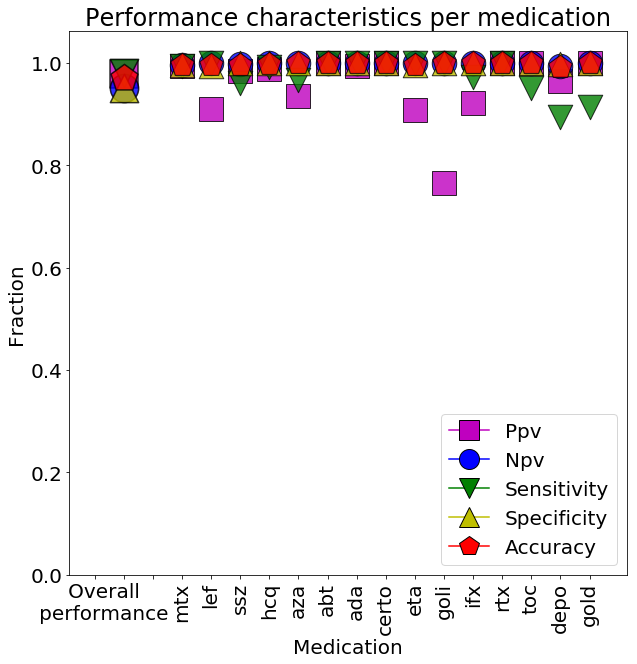

In [17]:
# Making performance plot by providing a dataframe
#print(d_performance)
plt.rcParams.update({'font.size': 20})
plt = performancePlot(d_performance, 'Performance characteristics per medication')
plt.figsize=(10, 10)
plt.savefig('PerformancePerMed_Groups.png', bbox_inches='tight')
plt.ylim(ymin=0)
plt.ylabel('Fraction')
plt.xlabel('Medication')
plt.show()



# Step 7: Processing Context
### Here is a notebook for [the Context Processing](./ContextPipeline.ipynb)

## TESTING OUT PATTERN

In [38]:

import pattern.nl as lemD
from pattern.nl import conjugate, lemma, lexeme, parsetree, sentiment, parse

print(' '.join(lemD.Sentence(lemD.parse(sentence, lemmata=True)).lemmata))
#print(lexeme('verhogen'))
#print(lemma('verhoog'))

#print(conjugate('verhogen', '1sg'))

sentence = 'verhogen methotrexaat concentratie naar 10 mg'
sticky_chars = r'([!#?,.:";@\-\+\\/&=$\]\[<>\'\*`â€™\(\)\d])'
sentence = re.sub(sticky_chars, r' ', sentence)
words = sentence.split()


verhoog methotrexaat concentratie naar mg


In [28]:
from pattern.en import sentiment

print(sentiment("The movie attempts to be surreal by incorporating various time paradoxes,"
"but it's presented in such a ridiculous way it's seriously boring.") )
print(sentiment('Wonderfully awful! :-)').assessments)
# Polarity | Subjectivity

(-0.21666666666666665, 0.8)


In [22]:
from pattern.nl import sentiment

print(sentiment("- mede op verzoek van patient nu al mtx langzaam omlaag") )
#print(sentiment("wel jarig") )
print(sentiment("- mede op verzoek van patient nu al mtx langzaam omlaag").assessments)
#print()
#print(suggest("concentratie"))
#print(suggest("start"))

(-0.4, 0.7)
[(['langzaam'], -0.4, 0.7, None)]


## Natural Language Processing | Feature extraction


### Reading df_REUBEL table & Removing Stopwords 

In [ ]:
df_REUBEL = read_csv(r'output_files/DF_REUBEL.csv')
pc_df = em.Processing(df_REUBEL)

In [13]:
import spacy # module staat nog niet op shark

nlp = spacy.load(r'E:\modules\Anaconda\Program\Lib\site-packages\nl_core_news_sm\nl_core_news_sm-2.0.0', parse=True, tag=True, entity=True)
sent = "D"

def removeStop(sent):
    # zo door -> door wordt gezien als Stop woord!
    proc_sent = ""
    doc = nlp(sent)
    for word in doc:
        if (word.is_stop == False) or (word.dep_ == 'advmod' or word.dep_ == 'nmod'):
            proc_sent += str(word) + " "
    return proc_sent

df_nlp = df_REUBEL
df_nlp['XANTWOORD'] = df_REUBEL['XANTWOORD'].apply(lambda x: removeStop(str(x)))
df_nlp.to_csv('output_files/REUBEL_nlp.csv', sep='|')
df_nlp = read_csv('output_files/REUBEL_nlp.csv')

## Exploring Tinekes Data

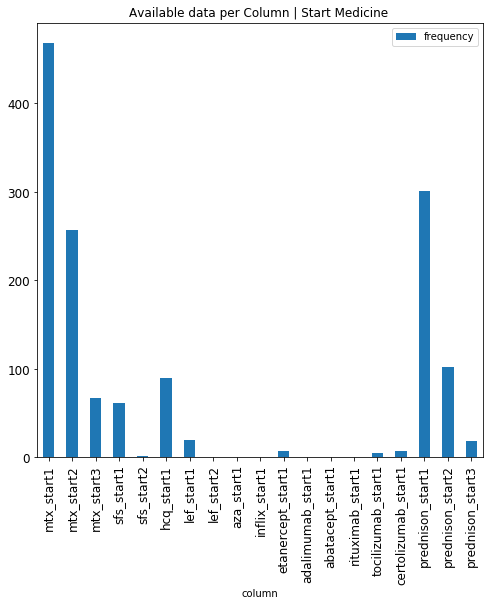

In [64]:
pyplt.figure(figsize=(6, 6))
df_gold = em.read_csv(r'input_files/EMR_goldenstandard.csv')
acronyms_pattern = re.compile(r'\b({})\b'.format('|'.join(ACRONYM_MAP.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)

med_list = []
col_list = []
for column in df_gold:
    word = column.split('_')[0]
    if word in ACRONYM_MAP or word in MEDICINE or word == 'sfs':
        if word in ACRONYM_MAP:
            word = acronyms_pattern.sub(ACRONYM_MAP[word], word)
        if word not in med_list:
            med_list.append(word)
        if 'start' in column and 'startweek' not in column and 'startbznr' not in column:
            col_list.append(column)
        
df_med = df_gold[col_list] 

c_med = df_med.replace(r'\s+', np.nan, regex=True).count()
freq_list = []
for x in range(len(c_med)):
    freq_list.append(c_med[x])

df = pd.DataFrame({'column':col_list, 'frequency':freq_list})
ax = df.plot(kind='bar', title ="Available data per Column | Start Medicine ", x='column', figsize=(8, 8), legend=True, fontsize=12, rot=90)
pyplt.savefig('figures/exploringData/goldTinekeMedDist.png', bbox_inches="tight")


## Step 8: METEOR

In [7]:
import re
df_HIXMET = pd.read_excel('input_files/LUMC_Hix_nummers_METEOR.xlsx')
#print(getDim(df_HIXMET))
#
df_HIXMET['pinCode'] = df_HIXMET['pinCode'].str.replace('\.', '', regex=True)
df_HIXMET['pinCode'] = df_HIXMET['pinCode'].str.replace('[a-zA-Z]', '', regex=True)
df_HIXMET = df_HIXMET.dropna(subset=['pinCode'])
df_HIXMET.head(8)

TypeError: replace() got an unexpected keyword argument 'regex'

In [51]:
#a5 = df_HIXMET['pinCode'].unique()

a5 = pd.to_numeric(df_HIXMET['pinCode'])
a5 = a5[a5 != np.array(None)]
a6 = df_proc['PATNR'].unique()
a6 = a6[a6 != np.array(None)]



# later vervangen met patient id indien er sprake is van overlap
print(len(np.intersect1d(a5, a6)))

print(getDim(df_proc))
df_proc = df_proc[df_proc['PATNR'].isin(np.intersect1d(a5, a6))]
print(df_proc['PATNR'].head(5).apply(lambda x : df_HIXMET.loc[df_HIXMET['pinCode'] == x, 'patientId']))



#df_proc['patient_id'] = df_proc['PATNR'].apply(lambda x : df_HIXMET[df_HIXMET['pinCode']
#df_proc['patient_id'] = df_proc['PATNR'].apply(lambda x : df_HIXMET[df_HIXMET['pinCode'] == x]['patientId'] )
#print(df_proc.head(5)['PATNR', 'patient_id', 'XANTWOORD'])

2627
Rows: 54577	Columns: 57
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [26]:

df_MET = pd.read_stata('METEOR_Tjardo.dta')
#df_MET.patientId = df_MET.patientId.astype(int)
#df_MET.patientId = df_MET.patientId.astype(str)

print(getDim(df_MET))
print(getHeaders(df_MET))
#print(len(df_MET['patientId'].unique()))   LKeTdEvN3fI3MliVyoEJeQ==

Rows: 34805	Columns: 1801
['newpatientid', 'VisitUniqueId', 'patientId', 'Betamethasone1Name', 'Betamethasone1StartDate', 'Betamethasone1EndDate', 'Betamethasone1Amount', 'Betamethasone1Strength', 'Betamethasone1Dosage', 'Betamethasone1Iter', 'Betamethasone1Interval', 'Betamethasone1StopReason', 'Betamethasone1iaInjection', 'Betamethasone1jointCode', 'Betamethasone2Name', 'Betamethasone2StartDate', 'Betamethasone2EndDate', 'Betamethasone2Amount', 'Betamethasone2Strength', 'Betamethasone2Dosage', 'Betamethasone2Iter', 'Betamethasone2Interval', 'Betamethasone2StopReason', 'Betamethasone2iaInjection', 'Betamethasone2jointCode', 'Betamethasone3Name', 'Betamethasone3StartDate', 'Betamethasone3EndDate', 'Betamethasone3Amount', 'Betamethasone3Strength', 'Betamethasone3Dosage', 'Betamethasone3Iter', 'Betamethasone3Interval', 'Betamethasone3StopReason', 'Betamethasone3iaInjection', 'Betamethasone3jointCode', 'Cortivazol1Name', 'Cortivazol1StartDate', 'Cortivazol1EndDate', 'Cortivazol1Amount', '

In [27]:
a7 = pd.to_numeric(df_HIXMET['patientId'])
a7 = a7[a7 != np.array(None)]
a8 = df_MET['patientId'].unique()
a8 = a8[a8 != np.array(None)]

print(len(np.intersect1d(a7, a8)))

3432


#### Determine overlap DDR_A and METEOR

In [ ]:
a5 = df_MET['patientId'].unique()
print(df_MET['patientId'].unique()[0]) 
a5 = a5[a5 != np.array(None)]
a6 = df_REU['PATNR'].unique()
print(df_REU['PATNR'].unique()[0]) 
a6 = a6[a6 != np.array(None)]
print(len(np.intersect1d(a5, a6)))

# Determine why these patients are missing in the MedicatieVoorschrift Table
#print(np.setdiff1d(a4, a3)[:5])

#print(getHeaders(df_ddrA.head(5)))

In [23]:
df_MET['DAS4_ESRrecalculated'].unique()

array([3.66666198, 3.12362862, 1.0238204 , ..., 3.53384805, 2.65899587,
       2.47008109])

df_MET[df_MET['patientId'] == 8797093022725.0]
#print(df_MET['patientId'].unique()[0])
#df_MET.head()

### Zoektocht naar gewrichtspop

In [ ]:
#df_REU.head(5)
print(getHeaders(df_REU))
#print(len(df_REU['DOSSIERID'].unique()))
#print(len(df_REU['DATUM'].unique()))
#print(df_REU['STELLING'].unique())

#txt_allopt = open("Allopt.txt", "w")
#for x in df_REU['STELLING'].unique():
#    txt_allopt.write(str(x) + "\n")
#txt_allopt.close()

#makeFile('Allopt.txt', df_REU['STELLING'].unique())
makeFile('Allopt2.txt', df_ddrA['STELLING'].unique())

print(df_ddrA[df_ddrA['STELLING'] == 'Gewrichtspop'])

df_REU[df_REU['ANTWOORD'].str.contains('Gewrichtspop')][['ANTWOORD', 'PATNR','STELLING']].head(22)
#mylist = ['gewrichtspop']
makeFile('Output.txt', df_REU[df_REU['ANTWOORD'].str.contains('Gewrichtspop')]['ANTWOORD'])

#mel_count= df_REU['ANTWOORD'].str.contains('gewrichtspop').sum()
#if mel_count>0:
#    print ("There are {m} Mels".format(m=mel_count))

#s.isin(['gewrichtspop'])

### Checking wheter or not Medications are mentioned in the conclusion of the converted METEOR data (< 2011) 

Answer: No Medication found in converted METEOR data

In [13]:
df_conc = df_REU[df_REU['STELLING'] == 'Conclusie']
df_conc = df_conc[df_conc['XANTWOORD'].str.contains('conversie gegevens meteor')]

def checkForMed(text):
    med_found = False
    for x in re.split(' |, |\&|\n',text):
        #print(x)
        if str(x) in MEDICINE:
            med_found = True
            break
    return med_found

df_conc['XANTWOORD'] = df_conc['XANTWOORD'].apply(lambda x: handle_stickychars(str(x)))
df_conc['XANTWOORD'] = df_conc['XANTWOORD'].apply(lambda x: handle_acronym(str(x)))
df_conc['XANTWOORD'] = df_conc['XANTWOORD'].apply(lambda x: handle_acronym(str(x)))


print('Medication in conclusion of converted METEOR data: ' + str(len(df_conc[df_conc['XANTWOORD'].apply(lambda x : checkForMed(x))]['XANTWOORD'])))

Medication in conclusion of converted METEOR data: 0


# Old steps

151 = 151
3343 3392


/usr/local/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


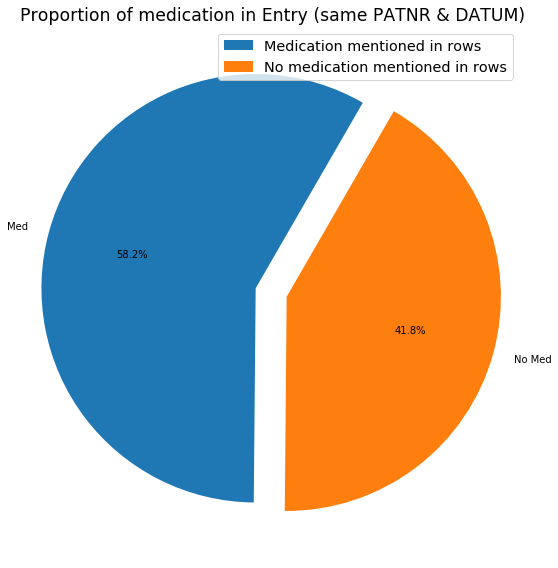

In [42]:
df_corrected, l_typo_found = pc_df.typoProcessing('XANTWOORD')
df_remain = df_corrected.drop(list(set(l_rows_visit))) # set -> to remove duplicates -> remove rows which are corrected
print(str(len(df_corrected)-len(df_remain)) + " = " + str(len(set(l_rows_visit)))) # These values should match
def getRowsMedicine(df):
    row_nr = 0
    l_med = []
    l_med_entry = []
    for row in df['XANTWOORD']:
        if any(xs in row for xs in MEDICINE):
            l_med.append(row_nr)
        row_nr += 1
    for row_nr in l_med:
        mask = (df['PATNR'] == df.iloc[int(row_nr)]['PATNR']) & (df['DATUM'] == df.iloc[int(row_nr)]['DATUM'])
        l_med_entry.extend(df.index[mask].tolist())
    print(str(len(l_med)) + " " + str(len(list(set(l_med_entry)))))
    return list(set(l_med_entry))

    
        
l_med = getRowsMedicine(df_remain)
df_nomed = df_remain.drop(l_med) # rijen niet hele beleid (kijkt niet naar visitdate)
df_notypo = df_remain.loc[l_med]

freq_list = [len(df_notypo), len(df_nomed)]
fig = pyplt.figure(figsize=[8, 8])
pyplt.pie(
    freq_list,
    labels=['Med', 'No Med'],
    shadow=False,
    explode=(0.15, 0),
    startangle=60,
    autopct='%1.1f%%',
    )

pyplt.axis('equal', labeldistance=-1.05)
pyplt.title('Proportion of medication in Entry (same PATNR & DATUM)', fontsize='xx-large')
pyplt.legend(freq_list, labels=['Medication mentioned in rows', 'No medication mentioned in rows'], loc="best", fontsize='x-large')

# View the plot
pyplt.tight_layout()
pyplt.show()

